## Activity inside ROI

Calculates the ROI for an embryo, using the structural channel to calculate the mask.

This code relies on the naming convention in this codebase to work properly: each embryo should have a file ending in `ch1.tif` (active channel) and another one ending in `ch2.tif` (structural channel).

To speed up the analysis, the ROI can be cached with the function `roi.cache_rois`, and passed to `activity.plot_activity` through the argument `mask_path`.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from pathlib import Path

import matplotlib.pyplot as plt
from tifffile import imread

from pasnascope import activity, find_hatching, roi, utils

experiment_name = '20240307'
root_dir = Path.cwd().parent
experiment_dir = root_dir.joinpath('data', experiment_name)

In [2]:
img_dir = experiment_dir.joinpath( 'embs')

# All structural channel movies end with the suffix ch2
active = sorted(img_dir.glob('*ch1.tif'), key=utils.sort_by_emb_name)
struct = sorted(img_dir.glob('*ch2.tif'), key=utils.sort_by_emb_name)

### Percentual error caused by downsampling

Percentual error caused by downsampling. 
The error is the percentual difference between the average values for each image slice.

In [ ]:
i = 1
print(f"Using embryo {active[i].stem}")
hp = find_hatching.find_hatching_point(active[i])
# adjust hatching point to match the downsample size
hp -= hp % 50

active_img = imread(active[i], key=range(0, hp))
struct_img = imread(struct[i], key=range(0, hp))

def activity_when_window(window):
    mask = roi.get_roi(struct_img, window=window)
    masked = activity.apply_mask(active_img, mask)
    return activity.get_activity(masked)

def get_error(observed, expected):
    return (observed - expected)/expected

base_activity = activity_when_window(1)

fig, ax = plt.subplots()

# relative error when sampling in steps of 50, 10, and 5
for i in [50, 10, 5]:
    diff = get_error(activity_when_window(i), base_activity)
    ax.plot(diff[:-100], label=f"{i}:1", alpha=0.7, linewidth=1)

ax.legend()
fig.suptitle('Percentual error for downsampling')
fig.canvas.header_visible = False
fig.canvas.resizable = False
plt.show()

Calculates `dff` for an image, sampled in intervals equal to `window`:

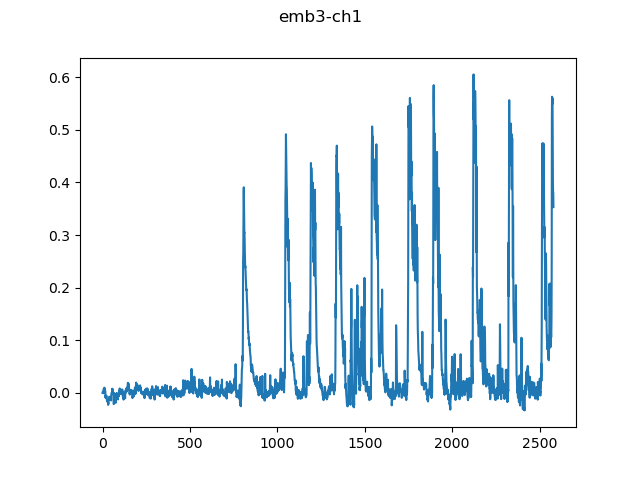

In [3]:
i = 3
window = 10

hp = find_hatching.find_hatching_point(struct[i])
# adjust hatching point to match the downsample size
hp -= hp % window

active_img = imread(active[i], key=range(hp))
struct_img = imread(struct[i], key=range(hp))

mask = roi.get_roi(struct_img, window=window)

masked_active = activity.apply_mask(active_img, mask)
masked_struct = activity.apply_mask(struct_img, mask)

signal_active = activity.get_activity(masked_active)
signal_struct = activity.get_activity(masked_struct)

r_signal = activity.ratiometric_activity(signal_active, signal_struct)
baseline = activity.compute_baseline(r_signal)

dff = activity.get_dff(r_signal, baseline)

fig, ax = plt.subplots()
ax.plot(dff, label='mask')
fig.suptitle(active[i].stem)
fig.canvas.header_visible = False
fig.canvas.resizable = False
plt.show()


Generate a csv file that can be parsed by the `pasna_fly` package.
Change the `file_name` to save as a different file.
Files are saved by default under the `results` directory.

In [11]:
file_name = 'preview.csv'
# The roi is calculated in steps of `window` size.
# This means that the slices from 0 to 10 will use the same 
# roi, that was calculated based on frame 0, for example.
window = 10


embryos = []
for i, _ in enumerate(active):
    hp = find_hatching.find_hatching_point(struct[i])
    # adjust hatching point to match the downsample size
    hp -= hp % window

    active_img = imread(active[i], key=range(hp))
    struct_img = imread(struct[i], key=range(hp))
    mask = roi.get_roi(struct_img, window=window)

    masked_active = activity.apply_mask(active_img, mask)
    masked_struct = activity.apply_mask(struct_img, mask)

    signal_active = activity.get_activity(masked_active)
    signal_struct = activity.get_activity(masked_struct)

    emb = [signal_active, signal_struct]

    embryos.append(emb)

dest = root_dir.joinpath('results')
dest.mkdir(parents=True, exist_ok=True)
file_path = dest.joinpath(file_name)

activity.export_csv(embryos, file_path);